<a href="https://colab.research.google.com/github/leoquiroa/TimeSeries/blob/master/Prophet/By_Month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# essentials
import numpy as np 
import pandas as pd 

# visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# time series algorithm
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from sklearn import preprocessing

from datetime import date
import holidays

# reproducibility
np.random.seed(34)

# Jupyter magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()

# Methods


In [0]:
def read_raw_csv(url,nrows):
  df_doc = pd.read_csv(
      url, 
      nrows=nrows,
      names = ['ds','cat','y'], 
      parse_dates = True )
  df_doc['ds'] = pd.to_datetime(df_doc['ds'])
  return df_doc

In [0]:
def filter_by(df_doc, name_doc):
  return df_doc[df_doc['cat'] == name_doc][['ds','y']].reset_index(drop=True)

In [0]:
def split_train_test(df_filter, date_start_test):
  split_point = df_filter[df_filter['ds']==date_start_test].index[0]
  train = df_filter[:split_point]
  test = df_filter[split_point:]
  return [train, test]

In [0]:
def compare_dates(date_begin, date_end, forecast, data):
  yhat = forecast[(forecast['ds'] >= date_begin) & (forecast['ds'] <= date_end)][['ds','yhat']][['ds','yhat']]
  yreal = data[(data['ds'] >= date_begin) & (data['ds'] <= date_end)]
  merged_inner = pd.merge(left=yreal,right=yhat, left_on='ds', right_on='ds')
  return merged_inner

In [0]:
def get_df_holidays(year_list):
  us_holidays = holidays.UnitedStates()
  mylist = []
  for date, name in sorted(holidays.US(years=year_list).items()):
    mylist.append((name,date,-1,0))
  df_holidays = pd.DataFrame(mylist, columns = ['holiday' , 'ds', 'lower_window' , 'upper_window'])
  return df_holidays

# Data preparation

In [0]:
url = 'https://raw.githubusercontent.com/leoquiroa/TimeSeries/master/Data/daily_revenue_doctor.csv'
df_doc = read_raw_csv(url, 4167)
df_filter = filter_by(df_doc, 'Robert Caputo')

In [0]:
df_filter = df_filter.set_index(pd.DatetimeIndex(df_filter['ds']))
df_filter = df_filter.drop('ds', axis=1)
revenue_x_m = df_filter.groupby([df_filter.index.year, df_filter.index.month]).sum()
revenue_x_m['info'] = revenue_x_m.index
revenue_x_m = revenue_x_m.reset_index(drop=True)
revenue_x_m['ds'] = revenue_x_m['info'].apply(lambda x : str(x[0])+'-'+str(x[1]))
revenue_x_m['ds'] = pd.to_datetime(revenue_x_m['ds'])+pd.tseries.offsets.MonthEnd(0)
revenue_x_m = revenue_x_m.drop('info', axis=1)

In [0]:
revenue_x_m = revenue_x_m[revenue_x_m['ds']>'2016-02-29']
revenue_x_m = revenue_x_m[revenue_x_m['ds']<'2019-12-31']
revenue_x_m = revenue_x_m[['ds', 'y']]

In [0]:
y = revenue_x_m['y'].to_frame()
min_max_scaler = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler.fit_transform(y)
ds_df = revenue_x_m['ds'].to_frame().reset_index(drop=True)
y_df = pd.DataFrame({'y': y_scaled[:, 0]})
revenue_x_m_norm = pd.concat([ds_df, y_df], axis=1)

In [0]:
[train,test] = split_train_test(revenue_x_m_norm, '2019-05-31')

In [49]:
print(train.shape)
print(test.shape)
test

(38, 2)
(7, 2)


,ds,y
38,2019-05-31,0.213847
39,2019-06-30,0.149857
40,2019-07-31,0.230267
41,2019-08-31,0.165413
42,2019-09-30,0.055453
43,2019-10-31,1.000000
44,2019-11-30,0.427472


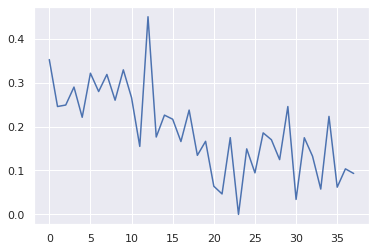

In [50]:
plt.plot(train['y'])

In [52]:
print(revenue_x_m_norm['y'].min())
print(revenue_x_m_norm['y'].mean())
print(revenue_x_m_norm['y'].median())
print(revenue_x_m_norm['y'].std())
print(revenue_x_m_norm['y'].max())

0.0
0.20969639892065786
0.17614530854688204
0.15677211897375745
1.0


# Simple Model

In [0]:
m = Prophet(weekly_seasonality=True, daily_seasonality=True)
m.fit(train)
future = m.make_future_dataframe(periods=7, freq='m')
forecast = m.predict(future)

In [55]:
  predict = forecast[(forecast['ds'] >= '2019-06-30') & (forecast['ds'] <= '2019-11-30')]
  predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
39,2019-06-30,0.096496,0.020961,0.138745,0.096496,0.096496,-0.019200,-0.019200,-0.019200,-0.019200,-0.019200,-0.019200,0.0,0.0,0.0,0.077296
40,2019-07-31,0.091045,0.005687,0.118173,0.091045,0.091045,-0.027749,-0.027749,-0.027749,-0.027749,-0.027749,-0.027749,0.0,0.0,0.0,0.063296
41,2019-08-31,0.085593,0.140541,0.256432,0.085593,0.085593,0.113083,0.113083,0.113083,0.113083,0.113083,0.113083,0.0,0.0,0.0,0.198676
42,2019-09-30,0.080318,-0.128937,-0.015433,0.080318,0.080318,-0.151099,-0.151099,-0.151099,-0.151099,-0.151099,-0.151099,0.0,0.0,0.0,-0.070781
43,2019-10-31,0.074866,0.060581,0.170838,0.074866,0.074867,0.038552,0.038552,0.038552,0.038552,0.038552,0.038552,0.0,0.0,0.0,0.113418


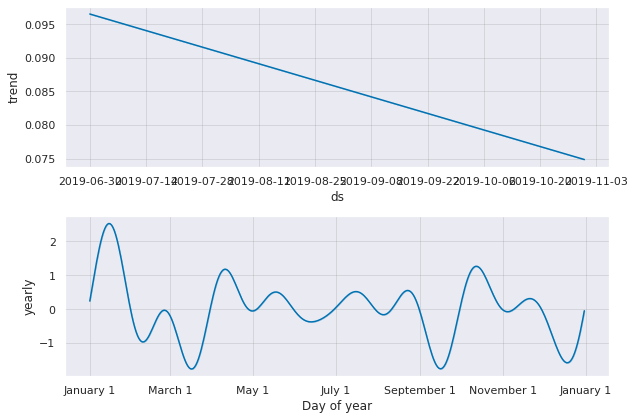

In [56]:
fig_decompose = m.plot_components(predict)

In [57]:
compare_dates('2019-06-30', '2019-11-30', forecast, test)

,ds,y,yhat
0,2019-06-30,0.149857,0.077296
1,2019-07-31,0.230267,0.063296
2,2019-08-31,0.165413,0.198676
3,2019-09-30,0.055453,-0.070781
4,2019-10-31,1.000000,0.113418


# Fourier Model order 5

In [58]:
print(train.shape)
print(test.shape)
test

(38, 2)
(7, 2)


,ds,y
38,2019-05-31,0.213847
39,2019-06-30,0.149857
40,2019-07-31,0.230267
41,2019-08-31,0.165413
42,2019-09-30,0.055453
43,2019-10-31,1.000000
44,2019-11-30,0.427472


In [0]:
m1 = Prophet(
    weekly_seasonality=False, 
    daily_seasonality=False, 
    n_changepoints=2)
m1.add_seasonality(
    name='monthly', 
    period=30.5, 
    fourier_order=5)
m1.fit(train)
future1 = m1.make_future_dataframe(periods=7, freq='M')
forecast1 = m.predict(future1)

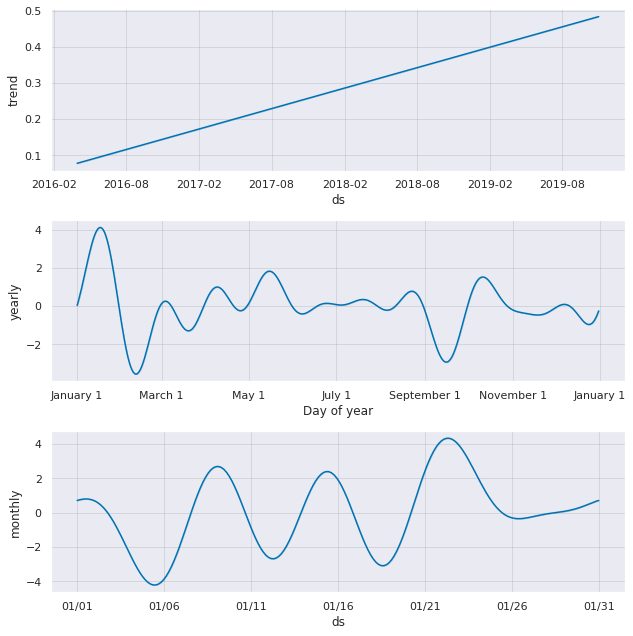

In [62]:
fig_decompose = m.plot_components(forecast1)

In [63]:
compare_dates('2019-06-30', '2019-11-30', forecast1, test)

,ds,y,yhat
0,2019-06-30,0.149857,0.225529
1,2019-07-31,0.230267,0.068809
2,2019-08-31,0.165413,0.212126
3,2019-09-30,0.055453,-0.111325
4,2019-10-31,1.000000,0.088447


# Model with Holidays

In [64]:
print(train.shape)
print(test.shape)
test

(38, 2)
(7, 2)


,ds,y
38,2019-05-31,0.213847
39,2019-06-30,0.149857
40,2019-07-31,0.230267
41,2019-08-31,0.165413
42,2019-09-30,0.055453
43,2019-10-31,1.000000
44,2019-11-30,0.427472


In [0]:
df_holidays = get_df_holidays([2016,2017,2018,2019])
m2 = Prophet(holidays=df_holidays,daily_seasonality=False,weekly_seasonality=False)
m2.add_country_holidays(country_name='US')
m2.fit(train)
future2 = m2.make_future_dataframe(periods=7, freq='m')
forecast2 = m2.predict(future)

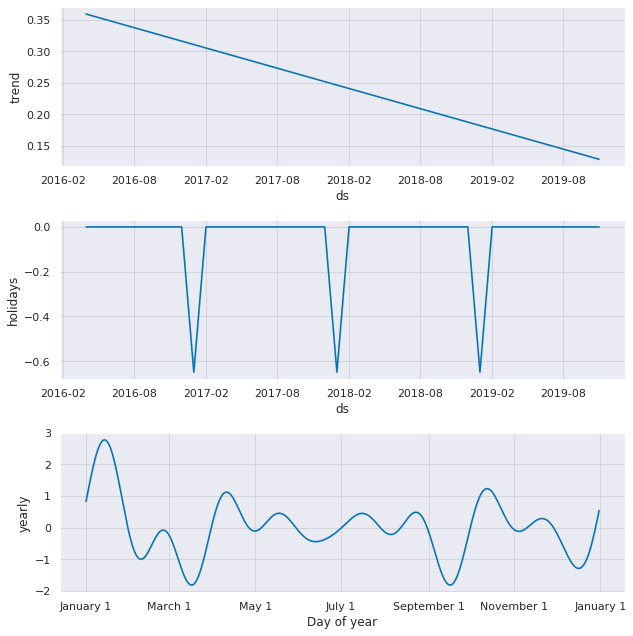

In [70]:
fig_decompose = m.plot_components(forecast2)

In [71]:
compare_dates('2019-06-30', '2019-11-30', forecast2, test)

,ds,y,yhat
0,2019-06-30,0.149857,0.077340
1,2019-07-31,0.230267,0.062870
2,2019-08-31,0.165413,0.197909
3,2019-09-30,0.055453,-0.071843
4,2019-10-31,1.000000,0.112693


# Compare Models

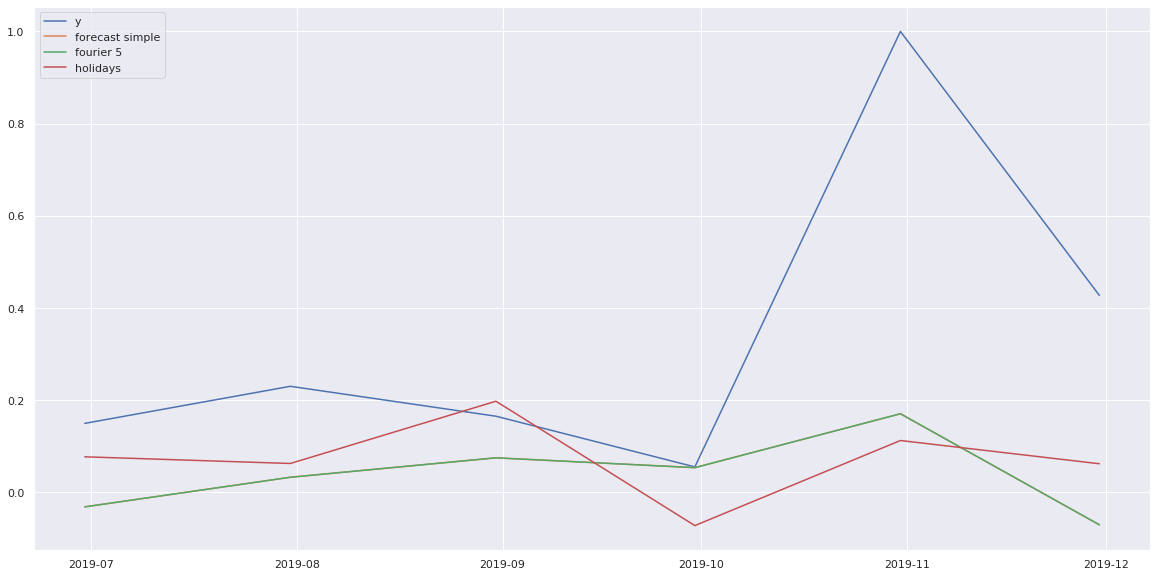

In [90]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(test[test['ds'] >= '2019-06-30']['ds'], test[test['ds'] >= '2019-06-30']['y'], label='y')
plt.plot(forecast[forecast['ds'] >= '2019-06-30']['ds'], forecast[forecast['ds'] >= '2019-06-30']['yhat'], label='forecast simple')
plt.plot(forecast1[forecast1['ds'] >= '2019-06-30']['ds'], forecast1[forecast1['ds'] >= '2019-06-30']['yhat'], label='fourier 5')
plt.plot(forecast2[forecast2['ds'] >= '2019-06-30']['ds'], forecast2[forecast2['ds'] >= '2019-06-30']['yhat'], label='holidays')
plt.legend(loc="upper left")

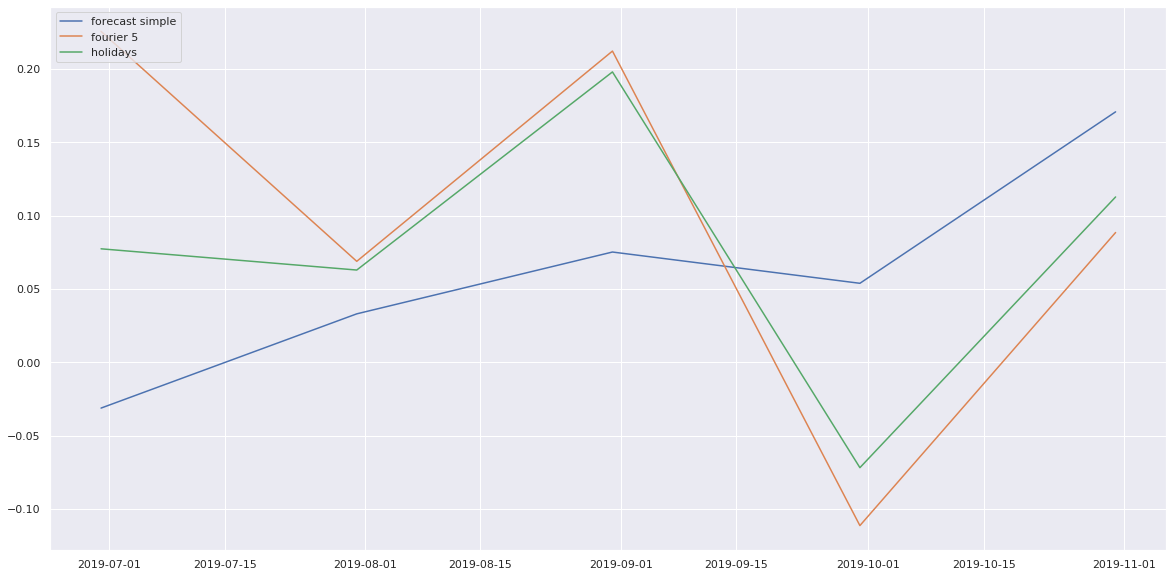

In [76]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(forecast[forecast['ds'] >= '2019-06-30']['ds'], forecast[forecast['ds'] >= '2019-06-30']['yhat'], label='forecast simple')
plt.plot(forecast1[forecast1['ds'] >= '2019-06-30']['ds'], forecast1[forecast1['ds'] >= '2019-06-30']['yhat'], label='fourier 5')
plt.plot(forecast2[forecast2['ds'] >= '2019-06-30']['ds'], forecast2[forecast2['ds'] >= '2019-06-30']['yhat'], label='holidays')
plt.legend(loc="upper left")

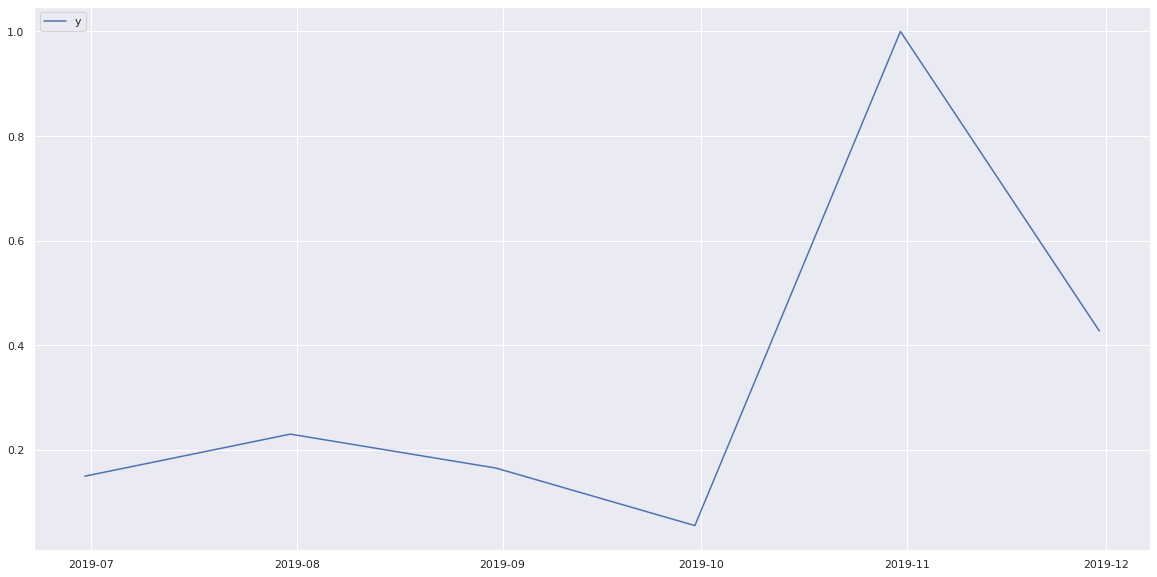

In [77]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(test[test['ds'] >= '2019-06-30']['ds'], test[test['ds'] >= '2019-06-30']['y'], label='y')
plt.legend(loc="upper left")